In [2]:
!pip install yfinance
import pandas as pd
import numpy as np
import yfinance as yf
import os
import scipy
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.utils import resample
import warnings
import pickle

CODE2STOCK={"UA":"UAL","AA":"AAL","AS":"ALK","B6":"JBLU","DL":"DAL","HA":"HA","NK":"SAVE","OO":"SKYW","WN":"LUV","G4":"ALGT"}
NO_STOCK=["EV","VX","9E","MQ","OH","YX","QX","F9","YV"]
NO_1HOT_COLS=["AIR_STOCK","DOW","NASDAQ","DEP_TIME","CRS_DEP_TIME","DEP_DELAY","DEP_DELAY_NEW","DEP_DEL15","TAXI_OUT","WHEELS_OFF","WHEELS_ON","TAXI_IN","CRS_ARR_TIME","ARR_TIME","ARR_DELAY","ARR_DELAY_NEW","ARR_DEL15","CANCELLED","DIVERTED","CRS_ELAPSED_TIME","ACTUAL_ELAPSED_TIME","AIR_TIME","FLIGHTS","DISTANCE"]
EX_BANNED=['DEP_TIME','DEP_DELAY','TAXI_OUT','WHEELS_OFF']
NEW_COLS=['NASDAQ','DOW','AIR_STOCK']

def _clean_bts_data(input_dir_path="./raw_bts_data",output_path="C:\\Users\\15513\\Desktop\\Flight-Delay-Prediction\\data\\data\\bts_data.csv"):
    df=None
    for f in os.listdir(input_dir_path):
        p = os.path.join(input_dir_path, f)
        if(type(df)==None):
            df=pd.read_csv(p)
        else:
            df=pd.concat([df,pd.read_csv(p)])
    df=df.dropna()
    for s in NO_STOCK:
        df=df[df["OP_UNIQUE_CARRIER"]!=s]
    df.to_csv(output_path,index=False)    

def _get_dow(input_path="C:\\Users\\15513\\Desktop\\Flight-Delay-Prediction\\raw_stock_data.zip\\raw_stock_data\\dow_data.csv"):
    df=pd.read_csv(input_path)
    df["Stock"]="DOW"
    df["YEAR"]=df.apply(lambda row: int(row["Date"].split("/")[2]),axis=1)
    df["MONTH"]=df.apply(lambda row: int(row["Date"].split("/")[0]),axis=1)
    df["DAY_OF_MONTH"]=df.apply(lambda row: int(row["Date"].split("/")[1]),axis=1)
    df=df.drop("Date",axis=1)
    return df

def _clean_stock_data(input_dow_path="C:\\Users\\15513\\Desktop\\Flight-Delay-Prediction\\raw_stock_data.zip\\raw_stock_data\\dow_data.csv",output_path="C:\\Users\\15513\\Desktop\\Flight-Delay-Prediction\\raw_stock_data.zip\\raw_stock_data\\dow_data.csv"):
    ranges=[("2017-12-01","2017-12-31"),
            ("2018-12-01","2018-12-31"),
            ("2019-12-01","2019-12-31"),
            ("2020-12-01","2020-12-31"),
            ("2021-12-01","2021-12-31"),
            ]
    stocks=list(CODE2STOCK.values())
    stocks.append("^IXIC")
    data=None
    for stock in stocks:
        for range in ranges:
            new = yf.download(stock, start=range[0], end=range[1])
            new["Stock"]=stock
            if(type(data)==None):
                data=new
            else:
                data=pd.concat([data,new])
    data=data.reset_index()
    data=data[["Date","Close","Stock"]]
    data["YEAR"]=data.apply(lambda row: row["Date"].year,axis=1)
    data["MONTH"]=data.apply(lambda row: row["Date"].month,axis=1)
    data["DAY_OF_MONTH"]=data.apply(lambda row: row["Date"].day,axis=1)
    data=data.drop("Date",axis=1)
    dow=_get_dow(input_dow_path)
    df=pd.concat([data,dow])
    df.to_csv(output_path,index=False)

def _match_stock(row,stock,stock_name):
    vals=stock[(stock["YEAR"]==row["YEAR"]) & (stock["MONTH"]==row["MONTH"]) & (stock["DAY_OF_MONTH"]==row["DAY_OF_MONTH"]) & (stock["Stock"]==stock_name)]["Close"].values
    if(len(vals)==0):
        return pd.NA
    else:
        return vals[0]

def _merge_bts_stock(bts_path="C:\\Users\\15513\\Desktop\\Flight-Delay-Prediction\\data\\data\\bts_data.csv",stock_path="C:\\Users\\15513\\Desktop\\Flight-Delay-Prediction\\data\\data\\stock_data.csv",output_path="C:\\Users\\15513\\Desktop\\Flight-Delay-Prediction\\data\\data\\all_data.csv"):
    bts=pd.read_csv(bts_path)
    stock=pd.read_csv(stock_path)
    bts["NASDAQ"]=bts.apply(lambda row: _match_stock(row,stock,"^IXIC"),axis=1)
    bts["DOW"]=bts.apply(lambda row: _match_stock(row,stock,"DOW"),axis=1)
    bts["AIR_STOCK"]=bts.apply(lambda row: _match_stock(row,stock,CODE2STOCK[row["OP_UNIQUE_CARRIER"]]),axis=1)
    df=bts.dropna()
    df.to_csv(output_path,index=False)

def _final_clean(output_path="C:\\Users\\15513\\Desktop\\Flight-Delay-Prediction\\data\\data\\all_data.csv"):
    df=load_data(separate=False)
    for col in df.columns:
        if(len(df[col].unique())<=1):
            df=df.drop(col,axis=1)
    df=df.drop(EX_BANNED,axis=1)
    df.to_csv(output_path,index=False)

def _preproc_features(df,save=False):
    cols=df.columns
    cols=[col for col in cols if col not in NO_1HOT_COLS]
    enc=OneHotEncoder().fit(df[cols])
    df1=enc.transform(df[cols])
    df2=df.drop(cols,axis=1)
    if(save):
        with open('./preproc.sav', 'wb') as file:
            pickle.dump({'enc':enc,'mean':df2.mean(),'std':df2.std()}, file)
    df2=(df2-df2.mean())/df2.std()
    df2=scipy.sparse.csr_matrix(df2.values)
    sp=scipy.sparse.hstack([df1,df2])
    return sp.astype(np.float32)

def _preproc_labels(df):
    return df["ARR_DEL15"].to_numpy(dtype=np.longlong)

def _resample(df):
    pos=df[df['ARR_DEL15']==1]
    neg=df[df['ARR_DEL15']==0]
    if(len(pos)>len(neg)):
        return pd.concat([neg,resample(pos, replace=False, n_samples=len(neg))])
    else:
        return pd.concat([pos,resample(neg, replace=False, n_samples=len(pos))])
    
def _subsample(df,perc):
    return resample(df, replace=False, n_samples=round(len(df)*perc))

def _no_covid_data(df):
    return df[df['YEAR']<2020]

def _covid_data(df):
    return df[df['YEAR']>=2020]

def preproc_features_df(df,ordinal=False):
    cols=df.columns
    cols=[col for col in cols if col not in NO_1HOT_COLS]
    if(ordinal):
        enc=OrdinalEncoder().set_output(transform="pandas")
        df1=enc.fit_transform(df[cols])
        return pd.concat([df1,df.drop(cols,axis=1)],axis=1)
    for col in cols:
        one_hot = pd.get_dummies(df[col],prefix=col)
        df = df.drop(col,axis = 1)
        df = df.join(one_hot)
    return df

def preproc_labels_df(df):
    return df["ARR_DEL15"]

def feature_label_split(df):
    labels=df["ARR_DEL15"].to_frame()
    features=df.drop("ARR_DEL15",axis=1)
    return features,labels

def preproc_data(features, labels):
    return _preproc_features(features),_preproc_labels(labels)

def load_data(input_path="C:\\Users\\15513\\Desktop\\Flight-Delay-Prediction\\data\\data\\all_data.csv",*,separate=True,resample=False,subsample=1.0,bts_only=False,covid=None,stock_only=False,select_features=False):
    df=pd.read_csv(input_path)
    if(select_features):
        df=df[['DAY_OF_MONTH','OP_UNIQUE_CARRIER','ORIGIN_AIRPORT_ID',
           'DEST_AIRPORT_ID','CRS_DEP_TIME', 'ARR_DEL15','NASDAQ', 'DOW', 'AIR_STOCK']]
    if(stock_only):
        nc=NEW_COLS
        nc.append('ARR_DEL15')
        df=df[nc]
    if(covid==True):
        df=_covid_data(df)
    elif(covid==False):
        df=_no_covid_data(df)
    if(bts_only):
        df=df.drop(NEW_COLS,axis=1)
    if(subsample != 1.0):
        df=_subsample(df,subsample)
    if(resample):
        df=_resample(df)
    if(separate==False):
        return df
    return feature_label_split(df)

def load_bts_data(input_path="C:\\Users\\15513\\Desktop\\Flight-Delay-Prediction\\data\\data\\all_data.csv",separate=True):
    warnings.warn('Deprecated and will be removed in a future version. Use load_data(bts_only=True) instead.')
    df=load_data(input_path,False)
    df=df.drop(NEW_COLS,axis=1)
    if(separate==False):
        return df
    return feature_label_split(df)

if __name__ == "__main__":
    pass

In [3]:
# Call the function without passing the separate argument
df = load_data()

# Call the function and pass the separate argument
df = load_data(separate=False)


In [4]:
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd

# get the string columns
cat_cols = df.drop(columns=['ARR_DEL15', 'DISTANCE']).columns.tolist()


# Fit and transform the encoder on the selected columns
encoder = OrdinalEncoder()
encoded_cols = encoder.fit_transform(df[cat_cols])

# Convert the encoded columns to a DataFrame
encoded_df = pd.DataFrame(encoded_cols, columns=cat_cols)

# Concatenate the encoded columns with the remaining columns
df_encoded = pd.concat([df.drop(columns=cat_cols), encoded_df], axis=1)

df_encoded

,ARR_DEL15,DISTANCE,YEAR,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_CITY_MARKET_ID,...,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_CITY_MARKET_ID,DEST_CITY_NAME,DEST_STATE_FIPS,DEST_WAC,CRS_DEP_TIME,NASDAQ,DOW,AIR_STOCK
0,0.0,1158.0,0.0,0.0,4.0,0.0,115.0,2568.0,93.0,17.0,...,40.0,279.0,275.0,267.0,44.0,19.0,298.0,14.0,90.0,486.0
1,0.0,1158.0,0.0,0.0,4.0,0.0,115.0,2600.0,279.0,275.0,...,19.0,93.0,17.0,80.0,41.0,40.0,578.0,14.0,90.0,486.0
2,0.0,918.0,0.0,0.0,4.0,0.0,115.0,385.0,93.0,17.0,...,40.0,169.0,94.0,153.0,7.0,14.0,783.0,14.0,90.0,486.0
3,0.0,918.0,0.0,0.0,4.0,0.0,115.0,385.0,169.0,94.0,...,14.0,93.0,17.0,80.0,41.0,40.0,1038.0,14.0,90.0,486.0
4,0.0,1021.0,0.0,0.0,4.0,0.0,116.0,2194.0,70.0,55.0,...,24.0,93.0,17.0,80.0,41.0,40.0,558.0,14.0,90.0,486.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345612,1.0,353.0,4.0,28.0,3.0,9.0,5863.0,436.0,192.0,187.0,...,49.0,231.0,177.0,229.0,4.0,49.0,768.0,95.0,36.0,388.0
1345613,1.0,650.0,4.0,28.0,3.0,9.0,5863.0,436.0,202.0,211.0,...,33.0,23.0,33.0,22.0,41.0,40.0,498.0,95.0,36.0,388.0
1345614,1.0,353.0,4.0,28.0,3.0,9.0,5863.0,437.0,231.0,177.0,...,49.0,192.0,187.0,186.0,4.0,49.0,888.0,95.0,36.0,388.0
1345615,1.0,353.0,4.0,28.0,3.0,9.0,5863.0,438.0,192.0,187.0,...,49.0,231.0,177.0,229.0,4.0,49.0,1008.0,95.0,36.0,388.0


In [5]:
df_pre_covid = df_encoded[df_encoded['YEAR'].isin([0,1,2])]
df_post_covid= df_encoded[df_encoded['YEAR'].isin([3,4])]


In [6]:
import pandas as pd
# Determine the class with the fewer samples.
counts = df_post_covid['ARR_DEL15'].value_counts()
minority_class = counts.idxmin()
minority_count = counts[minority_class]

# Select a random sample of the larger class with the same size as the smaller class.
majority_class = 1 - minority_class
majority_count = counts[majority_class]
majority_sample = df_post_covid[df_post_covid['ARR_DEL15'] == majority_class].sample(n=minority_count, random_state=0)

# Combine the two classes into a single DataFrame.
minority_df = df_post_covid[df_post_covid['ARR_DEL15'] == minority_class]
balanced_df = pd.concat([minority_df, majority_sample], axis=0)

balanced_df

,ARR_DEL15,DISTANCE,YEAR,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_CITY_MARKET_ID,...,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_CITY_MARKET_ID,DEST_CITY_NAME,DEST_STATE_FIPS,DEST_WAC,CRS_DEP_TIME,NASDAQ,DOW,AIR_STOCK
872555,1.0,912.0,3.0,0.0,1.0,0.0,155.0,199.0,72.0,86.0,...,17.0,156.0,111.0,143.0,41.0,40.0,993.0,60.0,0.0,11.0
872596,1.0,366.0,3.0,0.0,1.0,0.0,221.0,766.0,259.0,18.0,...,13.0,72.0,86.0,58.0,31.0,17.0,367.0,60.0,0.0,11.0
872614,1.0,986.0,3.0,0.0,1.0,0.0,255.0,2488.0,99.0,104.0,...,23.0,93.0,17.0,80.0,41.0,40.0,322.0,60.0,0.0,11.0
872677,1.0,2521.0,3.0,0.0,1.0,0.0,384.0,375.0,301.0,177.0,...,49.0,252.0,252.0,246.0,36.0,13.0,531.0,60.0,0.0,11.0
872678,1.0,1440.0,3.0,0.0,1.0,0.0,386.0,1909.0,253.0,38.0,...,41.0,239.0,78.0,62.0,11.0,21.0,438.0,60.0,0.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1205539,0.0,486.0,4.0,14.0,2.0,9.0,4624.0,5873.0,2.0,7.0,...,46.0,180.0,163.0,176.0,26.0,45.0,308.0,91.0,25.0,328.0
1263853,0.0,447.0,4.0,21.0,2.0,0.0,425.0,370.0,93.0,17.0,...,40.0,228.0,231.0,219.0,16.0,38.0,1033.0,90.0,30.0,94.0
1030244,0.0,1032.0,3.0,26.0,0.0,2.0,1443.0,1444.0,149.0,132.0,...,12.0,332.0,210.0,319.0,7.0,14.0,733.0,78.0,4.0,27.0
1138359,0.0,917.0,4.0,7.0,2.0,9.0,4407.0,4619.0,332.0,210.0,...,14.0,87.0,17.0,79.0,41.0,40.0,913.0,98.0,53.0,444.0


In [7]:
from sklearn.model_selection import train_test_split
# stratify make the split also balanced
X_train, X_test, y_train, y_test = train_test_split(balanced_df.drop(columns=['ARR_DEL15']), balanced_df['ARR_DEL15'], test_size=0.2, stratify=balanced_df['ARR_DEL15'], random_state=0)

In [8]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import GaussianNB

k = 10 # Number of top features to select
selector = SelectKBest(score_func=chi2, k=k)  # Choose appropriate score function
X_train_selected = selector.fit_transform(X_train, y_train)

# Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)
selected_features = X_train.columns[selected_feature_indices]
print("Selected features:", selected_features)
 



Selected features: Index(['DISTANCE', 'DAY_OF_MONTH', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'DEST_CITY_MARKET_ID', 'DEST_CITY_NAME', 'CRS_DEP_TIME', 'NASDAQ',
       'DOW', 'AIR_STOCK'],
      dtype='object')


In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create a GaussianNB classifier
clf = GaussianNB()

# Define the parameter grid for grid search
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

# Create a GridSearchCV object
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameter found by the grid search
print("Best var_smoothing:", grid_search.best_params_['var_smoothing'])

# Get the best classifier from the grid search
best_clf = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_clf.predict(X_test)

# Calculate accuracy of the best classifier on the test set
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", accuracy)



Best var_smoothing: 1e-06
Test accuracy: 0.6316273151420896


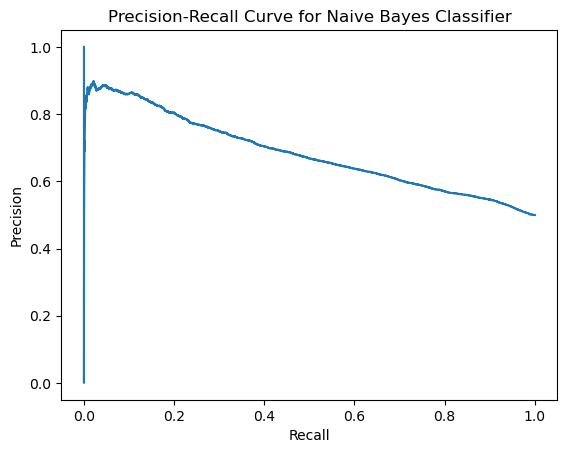

In [11]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Create a GaussianNB classifier
clf = GaussianNB()

# Fit the classifier to your data (assuming X_train and y_train are your training data)
clf.fit(X_train, y_train)

# Generate predicted probabilities for positive class
y_scores = clf.predict_proba(X_test)[:, 1]

# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Naive Bayes Classifier')
plt.show()


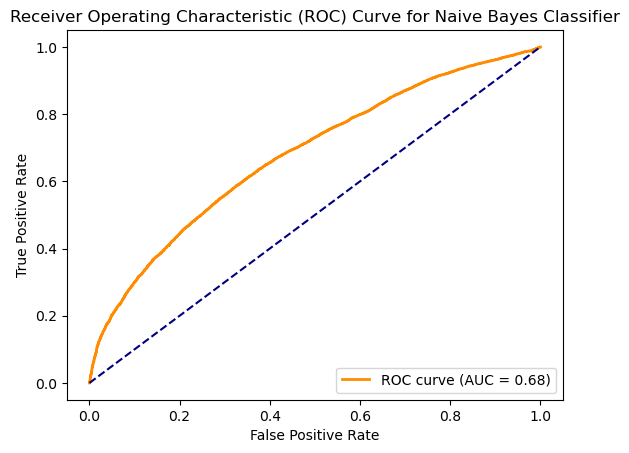

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Create a GaussianNB classifier
clf = GaussianNB()

# Fit the classifier to your data (assuming X_train and y_train are your training data)
clf.fit(X_train, y_train)

# Generate predicted probabilities for positive class
y_scores = clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Naive Bayes Classifier')
plt.legend(loc="lower right")
plt.show()



In [13]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, f1_score

# Create a GaussianNB classifier
clf = GaussianNB()

# Fit the classifier to your data (assuming X_train and y_train are your training data)
clf.fit(X_train, y_train)

# Generate predicted labels
y_pred = clf.predict(X_test)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)

# Display the calculated values
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)


Precision:  0.6042087233131461
Recall:  0.6988608221892025
F1 Score:  0.6480971128608923
